In [1]:
!pip install keras
!pip install sklearn
!pip install matplotlib
!pip install -U -q PyDrive

  Running setup.py bdist_wheel for sklearn ... - done
  Stored in directory: /content/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn


In [2]:
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [0]:
from keras import backend as K
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_import = drive.CreateFile({'id':'1p1bsltfTcIrZ_kfE6kwGTPzcdXorHbb2'})
file_import.GetContentFile('colab_setup.py') 
from colab_setup import setup

setup(drive)

In [6]:
!ls

colab_setup.py			 roc_auc_callback.py	X_train.npy
custom_fast_text_embeddings.npy  sample_submission.csv	X_val.npy
datalab				 train_model.py		y_test.npy
fast_text_embeddings.npy	 X_submission.npy	y_train_full.npy
plot_history.py			 X_test.npy		y_train.npy
__pycache__			 X_train_full.npy	y_val.npy


In [0]:
import numpy as np
import os

from plot_history import plot_history
from roc_auc_callback import RocAucCallback
from train_model import train_with_cv, train_with_submitting, evaluate_on_test

from keras.layers import *
from keras.layers.merge import *
from keras.initializers import *
from keras.models import Model

In [0]:
from keras.optimizers import *
from keras.initializers import *
from keras.layers import *
from keras.layers.merge import *
from keras.models import *

residual_convolution_options = dict({
    'dropout_mode': 'spatial',
    'dropout_rate': 0.2,
    'filters': 300,
    'kernel_size': 1,
    'strides': 1,
    'padding': 'same',
    'activation': 'elu',
    'should_preactivate': True
})

def convolution_block(input_layer, options):
    convolution_input = Input(shape=[
        int(input_layer.shape[1]),
        int(input_layer.shape[2])
    ])

    convolution_block = convolution_input

    if(options['should_preactivate']):
        convolution_block = BatchNormalization()(convolution_block)
        convolution_block = Activation(options['activation'])(convolution_block)
        convolution_block = Conv1D(options['filters'], options['kernel_size'], strides=options['strides'],
                                   padding=options['padding'], activation='linear', kernel_initializer='he_normal')(convolution_block)
    else:
        convolution_block = Conv1D(options['filters'], options['kernel_size'], strides=options['strides'],
                                   padding=options['padding'], activation='linear', kernel_initializer='he_normal')(convolution_block)
        convolution_block = BatchNormalization()(convolution_block)
        convolution_block = Activation(options['activation'])(convolution_block)

    convolution_output = convolution_block

    if(options['dropout_mode'] == 'spatial'):
        convolution_output = SpatialDropout1D(options['dropout_rate'])(convolution_output)
    if(options['dropout_mode']== 'vanilla'):
        convolution_output = Dropout(options['dropout_rate'])(convolution_output)

    return Model(inputs=[convolution_input], outputs=[convolution_output])(input_layer)

In [0]:
def residual_add_block(input_layer, should_pool):
    convolution_input = Input(shape=[
        int(input_layer.shape[1]),
        int(input_layer.shape[2])
    ])
    
    residual_block_pool = convolution_input

    if(should_pool):
        residual_block_pool = MaxPooling1D(pool_size=2, strides=2, padding='same')(convolution_input)

    residual_block = add([
        residual_block_pool,
        convolution_block(residual_block_pool, residual_convolution_options)
    ])
    residual_block = add([
        residual_block,
        convolution_block(residual_block, residual_convolution_options)
    ])
    
    convolution_output = add([residual_block, residual_block_pool])

    return Model(inputs=[convolution_input], outputs=[convolution_output])(input_layer)
  
def add_block(input_layer, should_pool):
    convolution_input = Input(shape=[
        int(input_layer.shape[1]),
        int(input_layer.shape[2])
    ])
    
    residual_block_pool = convolution_input

    if(should_pool):
        residual_block_pool = MaxPooling1D(pool_size=2, strides=2, padding='same')(convolution_input)

    residual_block = add([
        residual_block_pool,
        convolution_block(residual_block_pool, residual_convolution_options)
    ])
    residual_block = add([
        residual_block,
        convolution_block(residual_block, residual_convolution_options)
    ])
    
    convolution_output = residual_block
    
    return Model(inputs=[convolution_input], outputs=[convolution_output])(input_layer)

In [0]:
def yoon_kim_feature_extractor(input_layer, filters):
    extractor_block_input = Input(shape=[
        int(input_layer.shape[1]),
        int(input_layer.shape[2])
    ])

    block_1_conv_1 = Conv1D(filters, 1, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm1 = BatchNormalization()(block_1_conv_1)
    block_1_batchnorm1 = ELU()(block_1_batchnorm1)
    block_1_max_pool1 = GlobalMaxPooling1D()(block_1_batchnorm1)

    block_1_conv_2 = Conv1D(filters, 2, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm2 = BatchNormalization()(block_1_conv_2)
    block_1_batchnorm2 = ELU()(block_1_batchnorm2)
    block_1_max_pool2 = GlobalMaxPooling1D()(block_1_batchnorm2)

    block_1_conv_3 = Conv1D(filters, 3, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm3 = BatchNormalization()(block_1_conv_3)
    block_1_batchnorm3 = ELU()(block_1_batchnorm3)
    block_1_max_pool3 = GlobalMaxPooling1D()(block_1_batchnorm3)

    block_1_conv_4 = Conv1D(filters, 5, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm4 = BatchNormalization()(block_1_conv_4)
    block_1_batchnorm4 = ELU()(block_1_batchnorm4)
    block_1_max_pool4 = GlobalMaxPooling1D()(block_1_batchnorm4)

    features = concatenate([
        block_1_max_pool1, 
        block_1_max_pool2, 
        block_1_max_pool3, 
        block_1_max_pool4
    ])
    
    extractor_block_output = Dropout(0.2)(features)
    
    return Model(
        inputs=[extractor_block_input], 
        outputs=[extractor_block_output]
    )(input_layer)

In [0]:
def classification_block(input_layer, dropout_rate = 0.2):
      
    model = Dense(256, activation = 'linear', kernel_initializer = 'he_normal')(input_layer)
    model = BatchNormalization()(model)
    model = ELU()(model)
    model = Dropout(dropout_rate)(model)
    
    model = Dense(256, activation = 'linear', kernel_initializer = 'he_normal')(model)
    model = BatchNormalization()(model)
    model = ELU()(model)
    model = Dropout(dropout_rate)(model)

    classification_block_output = Dense(6, activation='sigmoid', kernel_initializer = 'glorot_normal')(model)
    
    return classification_block_output

In [12]:
max_words= 30000
max_words_length = 400
embedding_dimension = 300

input_layer = Input(shape=(max_words_length,))

pretrained_embedding_layer = Embedding(
    max_words, 
    output_dim=embedding_dimension, 
    input_length=max_words_length,
    weights = [np.load('fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
pretrained_embedding_layer = SpatialDropout1D(0.2)(pretrained_embedding_layer)

custom_embedding_layer = Embedding(
    max_words, 
    output_dim=embedding_dimension, 
    input_length=max_words_length,
    weights = [np.load('custom_fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
custom_embedding_layer = SpatialDropout1D(0.2)(custom_embedding_layer)

averaged_embedding_layer = Average()([pretrained_embedding_layer, custom_embedding_layer])
averaged_embedding_layer = SpatialDropout1D(0.2)(averaged_embedding_layer)

model = add_block(averaged_embedding_layer, should_pool = False)
model = add_block(model, should_pool = True)
model = add_block(model, should_pool = True)
model = add_block(model, should_pool = True)
model = add_block(model, should_pool = True)

output_layer = yoon_kim_feature_extractor(model, residual_convolution_options['filters'])
output_layer = classification_block(output_layer)

model = Model(input_layer, output_layer)

model.compile(loss='binary_crossentropy', 
            optimizer='Adam',
            metrics=['accuracy'])          

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 400, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
spatial_dr

In [13]:
history = train_with_cv(model, epochs=64, batchSize=32, rocEvery = 2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/64
 18496/102124 [====>.........................] - ETA: 4:53 - loss: 0.1274 - acc: 0.9565

 49536/102124 [=============>................] - ETA: 2:52 - loss: 0.0910 - acc: 0.9687

 80800/102124 [======================>.......] - ETA: 1:08 - loss: 0.0804 - acc: 0.9722

102124/102124 [==============================] - 349s 3ms/step - loss: 0.0756 - acc: 0.9737 - val_loss: 0.0525 - val_acc: 0.9805
Epoch 2/64
  4032/102124 [>.............................] - ETA: 5:09 - loss: 0.0570 - acc: 0.9790

 35264/102124 [=========>....................] - ETA: 3:30 - loss: 0.0564 - acc: 0.9795

 66880/102124 [==================>...........] - ETA: 1:50 - loss: 0.0561 - acc: 0.9796

 98912/102124 [============================>.] - ETA: 10s - loss: 0.0560 - acc: 0.9796

102124/102124 [==============================] - 342s 3ms/step - loss: 0.0562 - acc: 0.9796 - val_loss: 0.0478 - val_acc: 0.9821
roc-auc: 0.978 - roc-auc_val: 0.9731                                                                                                    
Epoch 3/64
  7072/102124 [=>............................] - ETA: 4:58 - loss: 0.0548 - acc: 0.9800

 39872/102124 [==========>...................] - ETA: 3:15 - loss: 0.0526 - acc: 0.9804

 72352/102124 [====================>.........] - ETA: 1:33 - loss: 0.0526 - acc: 0.9805

102124/102124 [==============================] - 342s 3ms/step - loss: 0.0522 - acc: 0.9805 - val_loss: 0.0457 - val_acc: 0.9828
Epoch 4/64
   576/102124 [..............................] - ETA: 5:20 - loss: 0.0479 - acc: 0.9815

 32320/102124 [========>.....................] - ETA: 3:38 - loss: 0.0494 - acc: 0.9814

 65472/102124 [==================>...........] - ETA: 1:54 - loss: 0.0491 - acc: 0.9814

 98048/102124 [===========================>..] - ETA: 12s - loss: 0.0497 - acc: 0.9812

102124/102124 [==============================] - 341s 3ms/step - loss: 0.0495 - acc: 0.9813 - val_loss: 0.0437 - val_acc: 0.9836
roc-auc: 0.9847 - roc-auc_val: 0.9795                                                                                                    
Epoch 5/64
  6912/102124 [=>............................] - ETA: 4:58 - loss: 0.0484 - acc: 0.9816

 38656/102124 [==========>...................] - ETA: 3:18 - loss: 0.0488 - acc: 0.9814

 71616/102124 [====================>.........] - ETA: 1:35 - loss: 0.0483 - acc: 0.9818

102124/102124 [==============================] - 341s 3ms/step - loss: 0.0482 - acc: 0.9819 - val_loss: 0.0436 - val_acc: 0.9830
Epoch 6/64
   736/102124 [..............................] - ETA: 5:21 - loss: 0.0515 - acc: 0.9808

 33344/102124 [========>.....................] - ETA: 3:35 - loss: 0.0456 - acc: 0.9829

 64736/102124 [==================>...........] - ETA: 1:57 - loss: 0.0468 - acc: 0.9822

 96928/102124 [===========================>..] - ETA: 16s - loss: 0.0468 - acc: 0.9823

102124/102124 [==============================] - 341s 3ms/step - loss: 0.0468 - acc: 0.9823 - val_loss: 0.0458 - val_acc: 0.9823
roc-auc: 0.986 - roc-auc_val: 0.9821                                                                                                    
Epoch 7/64
  6528/102124 [>.............................] - ETA: 4:56 - loss: 0.0481 - acc: 0.9817

 38976/102124 [==========>...................] - ETA: 3:17 - loss: 0.0465 - acc: 0.9823

 71712/102124 [====================>.........] - ETA: 1:35 - loss: 0.0457 - acc: 0.9825

102124/102124 [==============================] - 340s 3ms/step - loss: 0.0456 - acc: 0.9826 - val_loss: 0.0432 - val_acc: 0.9831
Epoch 8/64
   992/102124 [..............................] - ETA: 5:19 - loss: 0.0407 - acc: 0.9847

 34208/102124 [=========>....................] - ETA: 3:34 - loss: 0.0443 - acc: 0.9831

 65408/102124 [==================>...........] - ETA: 1:55 - loss: 0.0445 - acc: 0.9830

 98944/102124 [============================>.] - ETA: 9s - loss: 0.0448 - acc: 0.9830 

102124/102124 [==============================] - 342s 3ms/step - loss: 0.0448 - acc: 0.9829 - val_loss: 0.0422 - val_acc: 0.9834
roc-auc: 0.9882 - roc-auc_val: 0.9828                                                                                                    
Epoch 9/64
  7392/102124 [=>............................] - ETA: 4:53 - loss: 0.0425 - acc: 0.9836

 39200/102124 [==========>...................] - ETA: 3:16 - loss: 0.0439 - acc: 0.9830

 71264/102124 [===================>..........] - ETA: 1:36 - loss: 0.0440 - acc: 0.9830

102124/102124 [==============================] - 341s 3ms/step - loss: 0.0440 - acc: 0.9830 - val_loss: 0.0412 - val_acc: 0.9841
Epoch 10/64
   672/102124 [..............................] - ETA: 5:20 - loss: 0.0580 - acc: 0.9777

 32800/102124 [========>.....................] - ETA: 3:36 - loss: 0.0426 - acc: 0.9833

 64672/102124 [=================>............] - ETA: 1:56 - loss: 0.0431 - acc: 0.9833

 97344/102124 [===========================>..] - ETA: 14s - loss: 0.0430 - acc: 0.9834

102124/102124 [==============================] - 340s 3ms/step - loss: 0.0432 - acc: 0.9834 - val_loss: 0.0421 - val_acc: 0.9837
roc-auc: 0.9895 - roc-auc_val: 0.9835                                                                                                    
Epoch 11/64
  6560/102124 [>.............................] - ETA: 4:57 - loss: 0.0420 - acc: 0.9837

 38976/102124 [==========>...................] - ETA: 3:16 - loss: 0.0427 - acc: 0.9834

 72224/102124 [====================>.........] - ETA: 1:32 - loss: 0.0421 - acc: 0.9835

102124/102124 [==============================] - 339s 3ms/step - loss: 0.0422 - acc: 0.9836 - val_loss: 0.0430 - val_acc: 0.9831

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.00017677669529803097.
Epoch 12/64
   800/102124 [..............................] - ETA: 5:18 - loss: 0.0326 - acc: 0.9879

 35296/102124 [=========>....................] - ETA: 3:27 - loss: 0.0410 - acc: 0.9842

 68832/102124 [===================>..........] - ETA: 1:43 - loss: 0.0414 - acc: 0.9839

102124/102124 [==============================] - 338s 3ms/step - loss: 0.0415 - acc: 0.9838 - val_loss: 0.0435 - val_acc: 0.9826
roc-auc: 0.9908 - roc-auc_val: 0.9858                                                                                                    
Epoch 13/64
   160/102124 [..............................] - ETA: 5:20 - loss: 0.0589 - acc: 0.9802

 33248/102124 [========>.....................] - ETA: 3:33 - loss: 0.0417 - acc: 0.9835

 65504/102124 [==================>...........] - ETA: 1:53 - loss: 0.0414 - acc: 0.9838

 99808/102124 [============================>.] - ETA: 7s - loss: 0.0412 - acc: 0.9839

102124/102124 [==============================] - 338s 3ms/step - loss: 0.0412 - acc: 0.9839 - val_loss: 0.0422 - val_acc: 0.9832
Epoch 14/64
 11840/102124 [==>...........................] - ETA: 4:39 - loss: 0.0420 - acc: 0.9837

 44192/102124 [===========>..................] - ETA: 2:59 - loss: 0.0400 - acc: 0.9842

 76800/102124 [=====================>........] - ETA: 1:18 - loss: 0.0406 - acc: 0.9840

102124/102124 [==============================] - 339s 3ms/step - loss: 0.0406 - acc: 0.9841 - val_loss: 0.0432 - val_acc: 0.9828
roc-auc: 0.9916 - roc-auc_val: 0.9866                                                                                                    
Epoch 15/64
  1792/102124 [..............................] - ETA: 5:13 - loss: 0.0413 - acc: 0.9840

 35424/102124 [=========>....................] - ETA: 3:26 - loss: 0.0398 - acc: 0.9844

 69056/102124 [===================>..........] - ETA: 1:42 - loss: 0.0400 - acc: 0.9843

102124/102124 [==============================] - 339s 3ms/step - loss: 0.0400 - acc: 0.9843 - val_loss: 0.0415 - val_acc: 0.9835
Epoch 16/64
    96/102124 [..............................] - ETA: 5:37 - loss: 0.0559 - acc: 0.9687

 33824/102124 [========>.....................] - ETA: 3:32 - loss: 0.0392 - acc: 0.9846

 66912/102124 [==================>...........] - ETA: 1:49 - loss: 0.0391 - acc: 0.9846

 99200/102124 [============================>.] - ETA: 9s - loss: 0.0391 - acc: 0.9846

102124/102124 [==============================] - 339s 3ms/step - loss: 0.0391 - acc: 0.9845 - val_loss: 0.0423 - val_acc: 0.9829
roc-auc: 0.9924 - roc-auc_val: 0.9873                                                                                                    
Epoch 17/64
  6944/102124 [=>............................] - ETA: 4:56 - loss: 0.0363 - acc: 0.9855

 37952/102124 [==========>...................] - ETA: 3:20 - loss: 0.0389 - acc: 0.9846

 71072/102124 [===================>..........] - ETA: 1:36 - loss: 0.0393 - acc: 0.9845

102124/102124 [==============================] - 340s 3ms/step - loss: 0.0389 - acc: 0.9845 - val_loss: 0.0422 - val_acc: 0.9829
Epoch 18/64
   608/102124 [..............................] - ETA: 5:21 - loss: 0.0353 - acc: 0.9877

 33824/102124 [========>.....................] - ETA: 3:32 - loss: 0.0382 - acc: 0.9849

 66752/102124 [==================>...........] - ETA: 1:49 - loss: 0.0382 - acc: 0.9847

 98816/102124 [============================>.] - ETA: 10s - loss: 0.0385 - acc: 0.9847

102124/102124 [==============================] - 339s 3ms/step - loss: 0.0386 - acc: 0.9847 - val_loss: 0.0429 - val_acc: 0.9826
roc-auc: 0.9928 - roc-auc_val: 0.9871                                                                                                    
Epoch 19/64
  7200/102124 [=>............................] - ETA: 4:55 - loss: 0.0379 - acc: 0.9849

 40192/102124 [==========>...................] - ETA: 3:12 - loss: 0.0378 - acc: 0.9849

 73888/102124 [====================>.........] - ETA: 1:27 - loss: 0.0380 - acc: 0.9849

102124/102124 [==============================] - 339s 3ms/step - loss: 0.0381 - acc: 0.9849 - val_loss: 0.0423 - val_acc: 0.9829


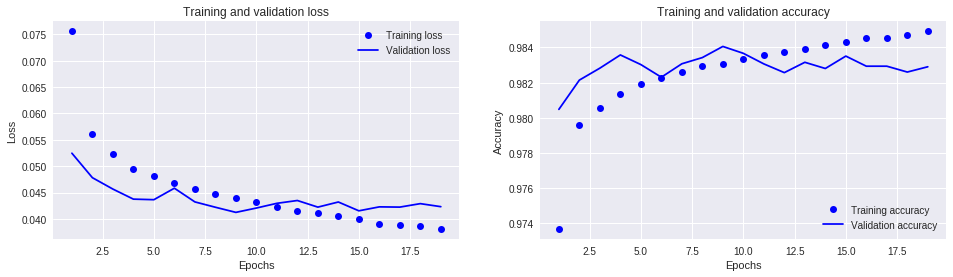

In [14]:
plot_history(history)

In [15]:
print(evaluate_on_test(model))

31915/31915 [==============================] - 29s 901us/step
([0.04142848959975569, 0.9831165989887447], 0.9895785020259819)
